### Yolov5 object detection model

Pre-requisites:

- ensure you have downloaded the DICOM data (download_data_lidc.ipynb)
- you have run prepared the training data for Yolov5 pytorch (yolov5_data_preparation.ipynb)

You have installed the followin using the console:

- apt-get update
- apt-get install ffmpeg libsm6 libxext6  -y

##### Imports

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 2.0 MB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 69.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 57.5 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 54.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 75.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 75.5 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 79.9 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 5.0 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 50.4 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 5.3 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████|

In [10]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys
from glob import glob
import os
import cv2
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import os
from numpy import random
import time
from PIL import Image
import contextlib
from tqdm import tqdm
import cv2
from pathlib import Path
import random
import math
%matplotlib inline

### Download the Yolov5 code and model from the repository

This notebook is based on git tag v6.0-39-g5d4258f from the repo https://github.com/ultralytics/yolov5

> !git rev-parse HEAD
- 5d4258fac5e6ceaa9c897f841cb737c56717a996

In [11]:
%pwd

'/app'

In [12]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd /app/yolov5
#!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

fatal: destination path 'yolov5' already exists and is not an empty directory.
/app/yolov5


In [13]:
%cd /app/yolov5
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
%pwd

/app/yolov5


'/app/yolov5'

In [14]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.0a0+52ea372 CPU


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [16]:
num_classes = 1

In [17]:
%%writetemplate /app/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [18]:
yolov5_data = '/app/data/yolov5/processed'
yolov5_model = '/app/yolov5'

In [19]:
ls -l /app/data/yolov5/processed/train/images/ | head

total 6640
-rw-r--r-- 1 root root  3404 Dec  2 17:53 LIDC-IDRI-0040_2.jpg
-rw-r--r-- 1 root root 11604 Dec  2 17:53 LIDC-IDRI-0040_28.jpg
-rw-r--r-- 1 root root  4005 Dec  2 17:53 LIDC-IDRI-0040_4.jpg
-rw-r--r-- 1 root root 13612 Dec  2 17:53 LIDC-IDRI-0040_42.jpg
-rw-r--r-- 1 root root 13733 Dec  2 17:53 LIDC-IDRI-0040_43.jpg
-rw-r--r-- 1 root root 13484 Dec  2 17:53 LIDC-IDRI-0040_44.jpg
-rw-r--r-- 1 root root 13917 Dec  2 17:53 LIDC-IDRI-0040_45.jpg
-rw-r--r-- 1 root root  5442 Dec  2 17:53 LIDC-IDRI-0040_8.jpg
-rw-r--r-- 1 root root 14353 Dec  2 17:53 LIDC-IDRI-0085_117.jpg
ls: write error


In [20]:
ls '{yolov5_model}/models'

__init__.py   custom_yolov5s.yaml  tf.py         yolov5m.yaml  yolov5x.yaml
__pycache__/  experimental.py      yolo.py       yolov5n.yaml
common.py     hub/                 yolov5l.yaml  yolov5s.yaml


In [21]:
ls {yolov5_data}

data.yaml  test/  train/  val/


### Train the model

In [22]:
%%writetemplate {yolov5_data}/data.yaml
train: /app/data/yolov5/processed/train
val: /app/data/yolov5/processed/val

nc: 1
names: ['nodule']

In [23]:
!cat {yolov5_data}/data.yaml

train: /app/data/yolov5/processed/train
val: /app/data/yolov5/processed/val

nc: 1
names: ['nodule']


### Hyper parameter tuning using Evolve

The base scenario in this example is finetuning LIDC-IDRI dataset for 10 epochs using pretrained YOLOv5s.

In [56]:
%%time
%cd /app/yolov5/
#!python train.py --img 512 --batch 64 --epochs 10 --data {yolov5_data}/data.yaml --hyp runs/evolve/yolov5s_results3/hyp_evolve.yaml --cfg {yolov5_model}/models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results --evolve --device 0,1
!python train.py --img 512 --batch 64 --epochs 10 --data {yolov5_data}/data.yaml --hyp runs/evolve/yolov5s_results3/hyp_evolve.yaml --cfg {yolov5_model}/models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results --evolve

/app/yolov5
train: weights=yolov5s.pt, cfg=/app/yolov5/models/custom_yolov5s.yaml, data=/app/data/yolov5/processed/data.yaml, hyp=runs/evolve/yolov5s_results3/hyp_evolve.yaml, epochs=10, batch_size=64, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=300, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.

In [24]:
!head -10 /app/yolov5/runs/evolve/yolov5s_results4/hyp_evolve.yaml

# YOLOv5 Hyperparameter Evolution Results
# Best generation: 30
# Last generation: 89
#    metrics/precision,       metrics/recall,      metrics/mAP_0.5, metrics/mAP_0.5:0.95,         val/box_loss,         val/obj_loss,         val/cls_loss
#              0.72986,              0.61437,              0.66673,              0.36867,             0.049835,             0.004287,                    0

lr0: 0.01027
lrf: 0.11246
momentum: 0.92855
weight_decay: 0.00078


In [59]:
%cd /app/yolov5/
import utils.plots
utils.plots.plot_evolve('/app/yolov5/runs/evolve/yolov5s_results4/evolve.csv')

/app/yolov5
            lr0: 0.00865
            lrf: 0.115
       momentum: 0.91
   weight_decay: 0.00077
  warmup_epochs: 4.01
warmup_momentum: 0.875
 warmup_bias_lr: 0.107
            box: 0.0551
            cls: 0.593
         cls_pw: 0.796
            obj: 1.11
         obj_pw: 1.39
          iou_t: 0.2
       anchor_t: 4.16
       fl_gamma: 0
          hsv_h: 0.0145
          hsv_s: 0.715
          hsv_v: 0.445
        degrees: 0
      translate: 0.0909
          scale: 0.423
          shear: 0
    perspective: 0
         flipud: 0
         fliplr: 0.5
         mosaic: 0.893
          mixup: 0
     copy_paste: 0
        anchors: 2.35
Saved /app/yolov5/runs/evolve/yolov5s_results4/evolve.png


In [121]:
ls /app/yolov5/runs/evolve/yolov5s_results/

evolve.csv  evolve.png  hyp.yaml  hyp_evolve.yaml  opt.yaml  results.csv


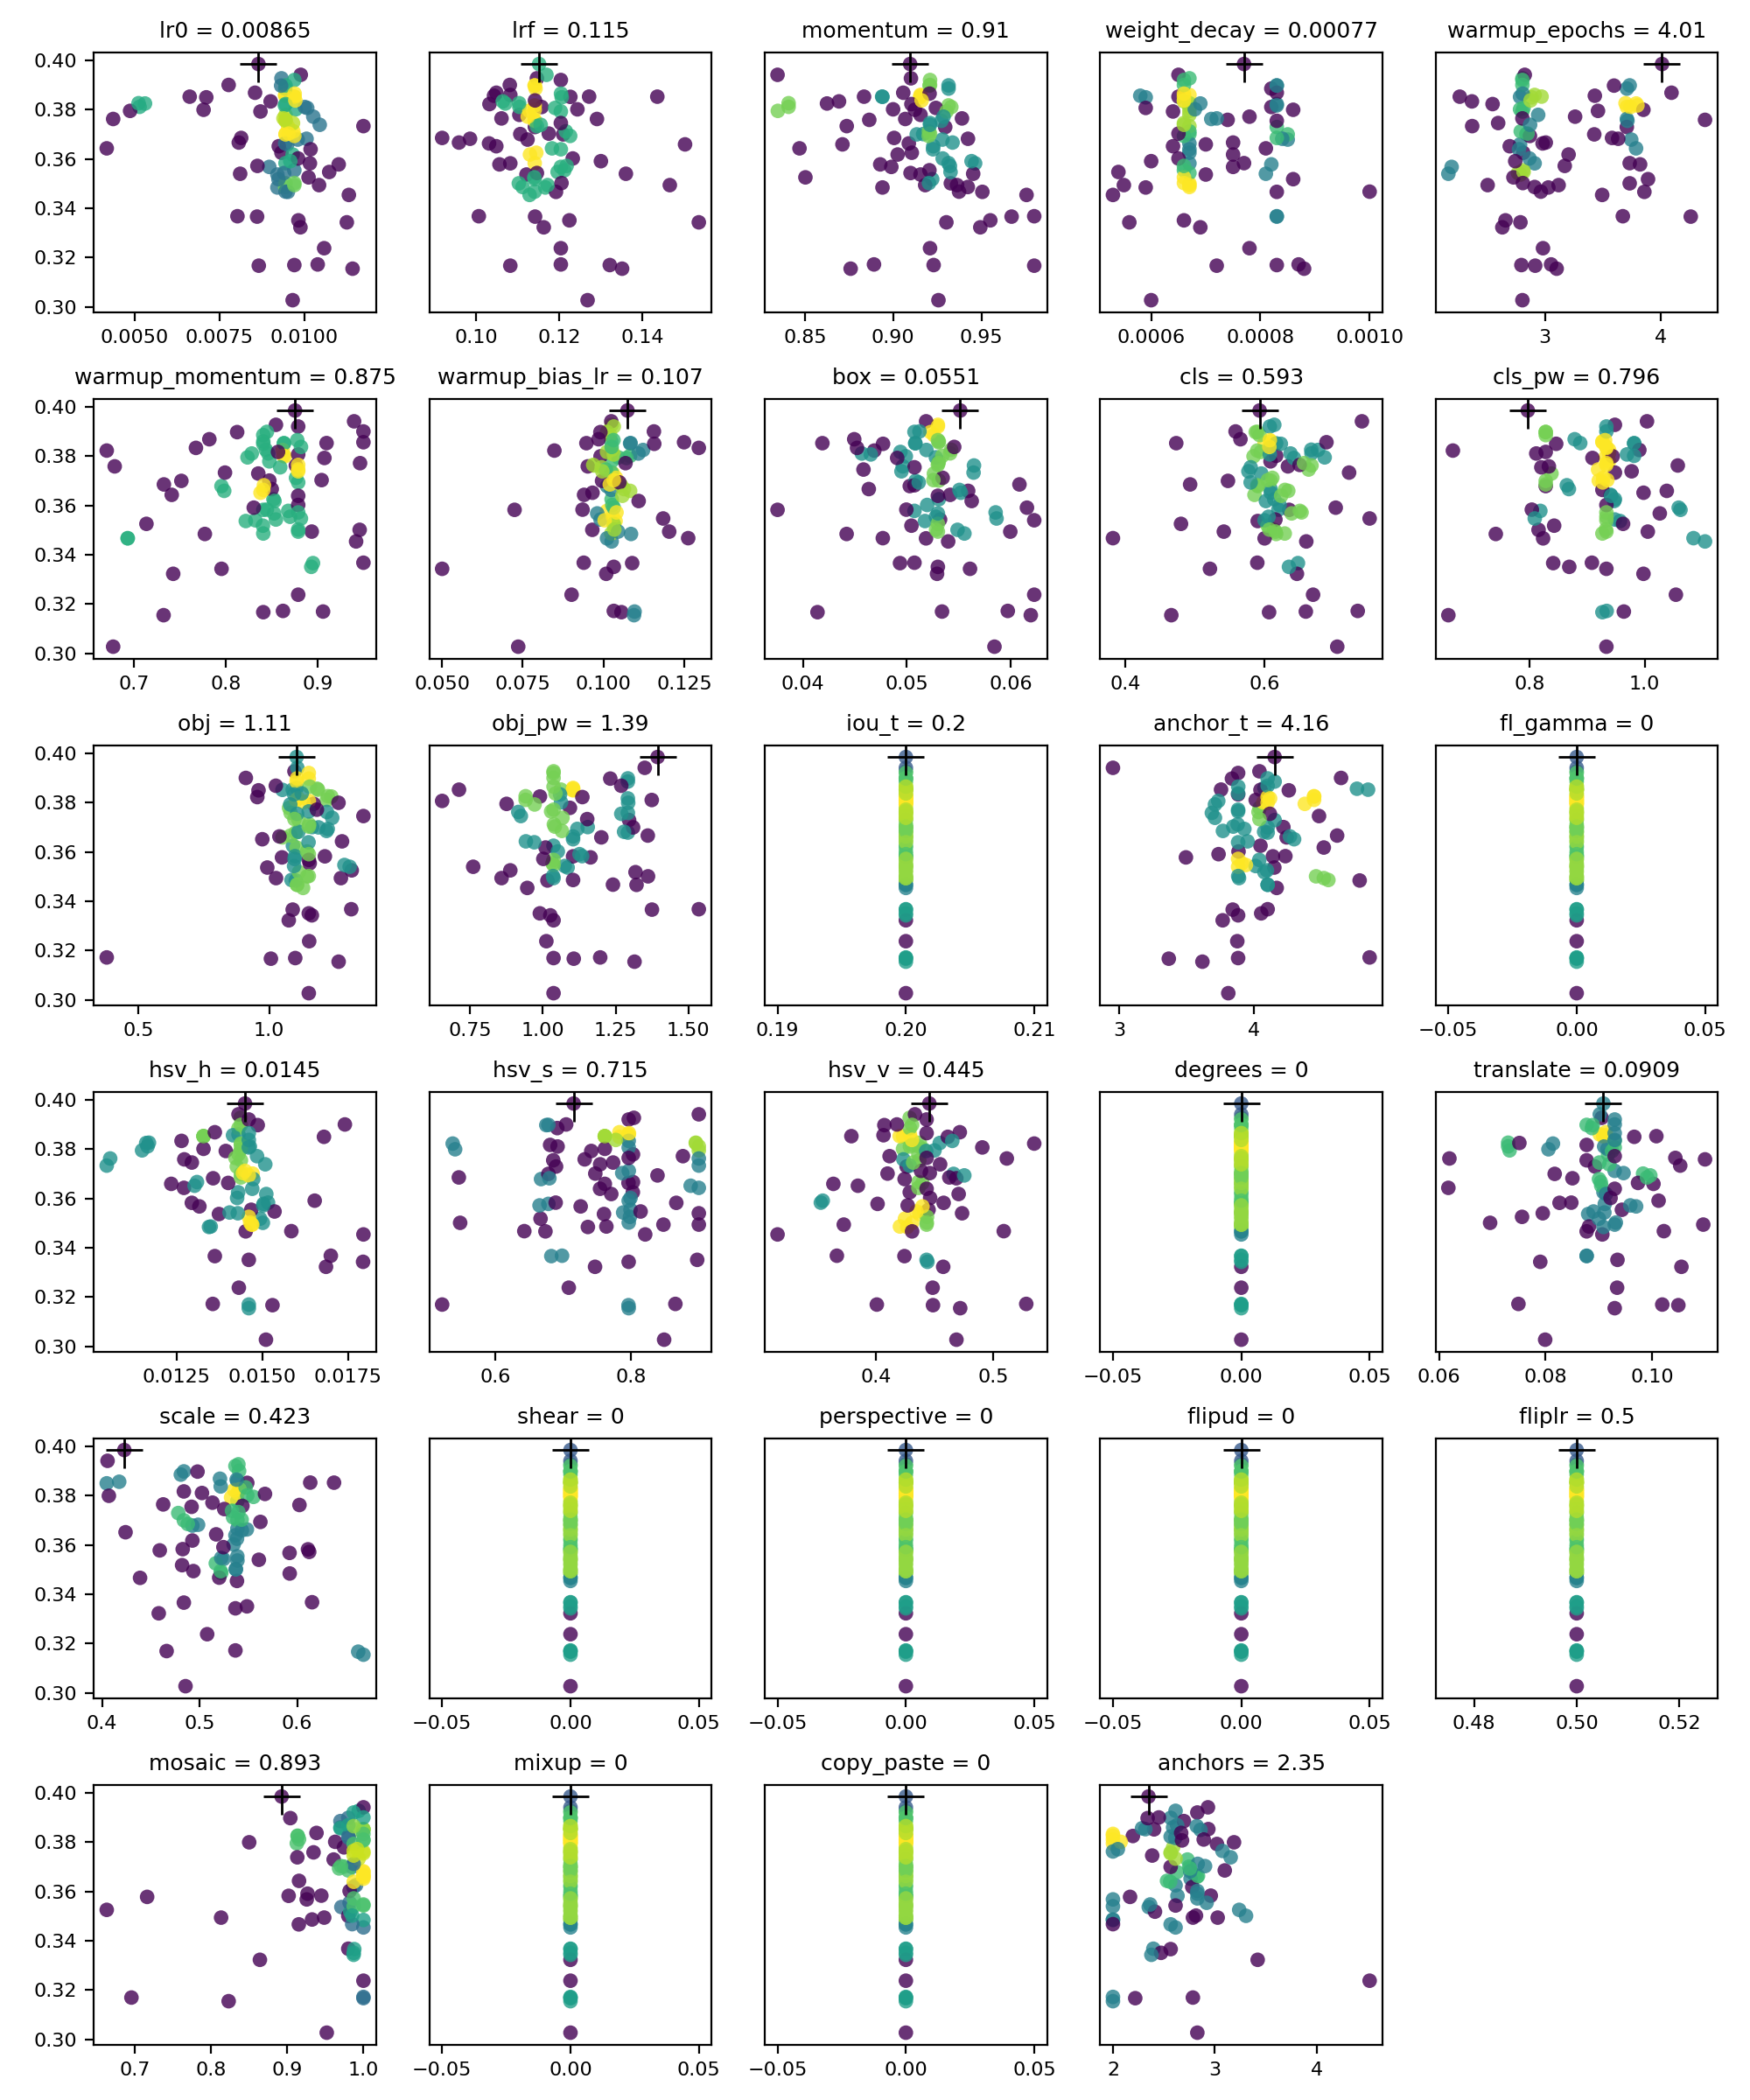

In [60]:
Image.open('/app/yolov5/runs/evolve/yolov5s_results4/evolve.png')

#### Training with tuned parameters

In [62]:
%%time
%cd /app/yolov5/
#!python train.py --img 512 --batch 64 --epochs 120 --data {yolov5_data}/data.yaml --cfg {yolov5_model}/models/custom_yolov5s.yaml --weights yolov5s.pt --hyp /app/yolov5/runs/evolve/yolov5s_results4/hyp_evolve.yaml --name yolov5s_results --device 0,1
!python train.py --img 512 --batch 64 --epochs 120 --data {yolov5_data}/data.yaml --cfg {yolov5_model}/models/custom_yolov5s.yaml --weights yolov5s.pt --hyp /app/yolov5/runs/evolve/yolov5s_results4/hyp_evolve.yaml --name yolov5s_results

/app/yolov5
train: weights=yolov5s.pt, cfg=/app/yolov5/models/custom_yolov5s.yaml, data=/app/data/yolov5/processed/data.yaml, hyp=/app/yolov5/runs/evolve/yolov5s_results4/hyp_evolve.yaml, epochs=120, batch_size=64, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/D

In [25]:
%cd /app/yolov5/
!ls runs/train/yolov5s_results30/

/app/yolov5
F1_curve.png					    results.png
PR_curve.png					    train_batch0.jpg
P_curve.png					    train_batch1.jpg
R_curve.png					    train_batch2.jpg
confusion_matrix.png				    val_batch0_labels.jpg
events.out.tfevents.1638249426.220ad55c310c.2759.0  val_batch0_pred.jpg
hyp.yaml					    val_batch1_labels.jpg
labels.jpg					    val_batch1_pred.jpg
labels_correlogram.jpg				    val_batch2_labels.jpg
opt.yaml					    val_batch2_pred.jpg
results.csv					    weights


##### Plot results
Use the utils package in Yolov5

In [78]:
from utils.plots import plot_results
plot_results('runs/train/yolov5s_results30/results.csv')

### Test prediction on one image

In [64]:
!python detect.py --weights runs/train/yolov5s_results30/weights/best.pt --img 512 --conf 0.4 --source /app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg

detect: weights=['runs/train/yolov5s_results30/weights/best.pt'], source=/app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg, imgsz=[512, 512], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 🚀 v6.0-39-g5d4258f torch 1.8.0a0+52ea372 CPU

Fusing layers... 
Model Summary: 213 layers, 7007428 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /app/d

In [65]:
ls runs/detect/exp94

LIDC-IDRI-0001_0_87.jpg


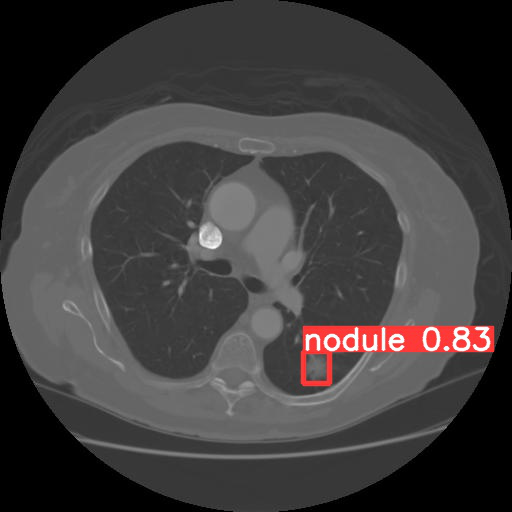

In [66]:
Image.open('runs/detect/exp94/LIDC-IDRI-0001_0_87.jpg')

### Testing

Run the validation on the test dataset

In [208]:
%%writetemplate {yolov5_data}/val.yaml
val: /app/data/yolov5/processed/test

nc: 1
names: ['nodule']

In [209]:
#!python val.py --weights runs/train/yolov5s_results30/weights/best.pt --data  {yolov5_data}/val.yaml  --conf 0.4 --device 0,1
!python val.py --weights runs/train/yolov5s_results28/weights/best.pt --data  {yolov5_data}/val.yaml  --conf 0.4

val: data=/app/data/yolov5/processed/val.yaml, weights=['runs/train/yolov5s_results28/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.4, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 🚀 v6.0-39-g5d4258f torch 1.8.0a0+52ea372 CPU

Fusing layers... 
Model Summary: 213 layers, 7007428 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/app/data/yolov5/processed/test/labels' images and labels...738 f
val: WARNING: /app/data/yolov5/processed/test/images/LIDC-IDRI-001

In [27]:
ls /app/yolov5/runs/evolve/yolov5s_results4

evolve.csv  evolve.png  hyp.yaml  hyp_evolve.yaml  opt.yaml  results.csv


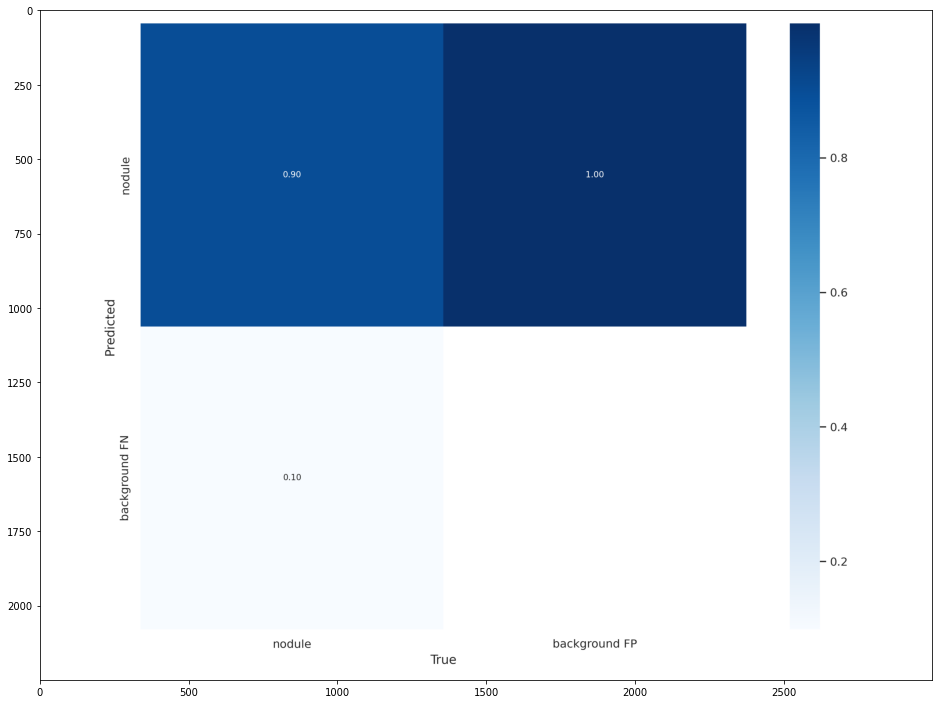

In [212]:
arr = Image.open('runs/val/exp2/confusion_matrix.png')
f,a = plt.subplots(figsize=(16,14))
a.imshow(np.array(arr))

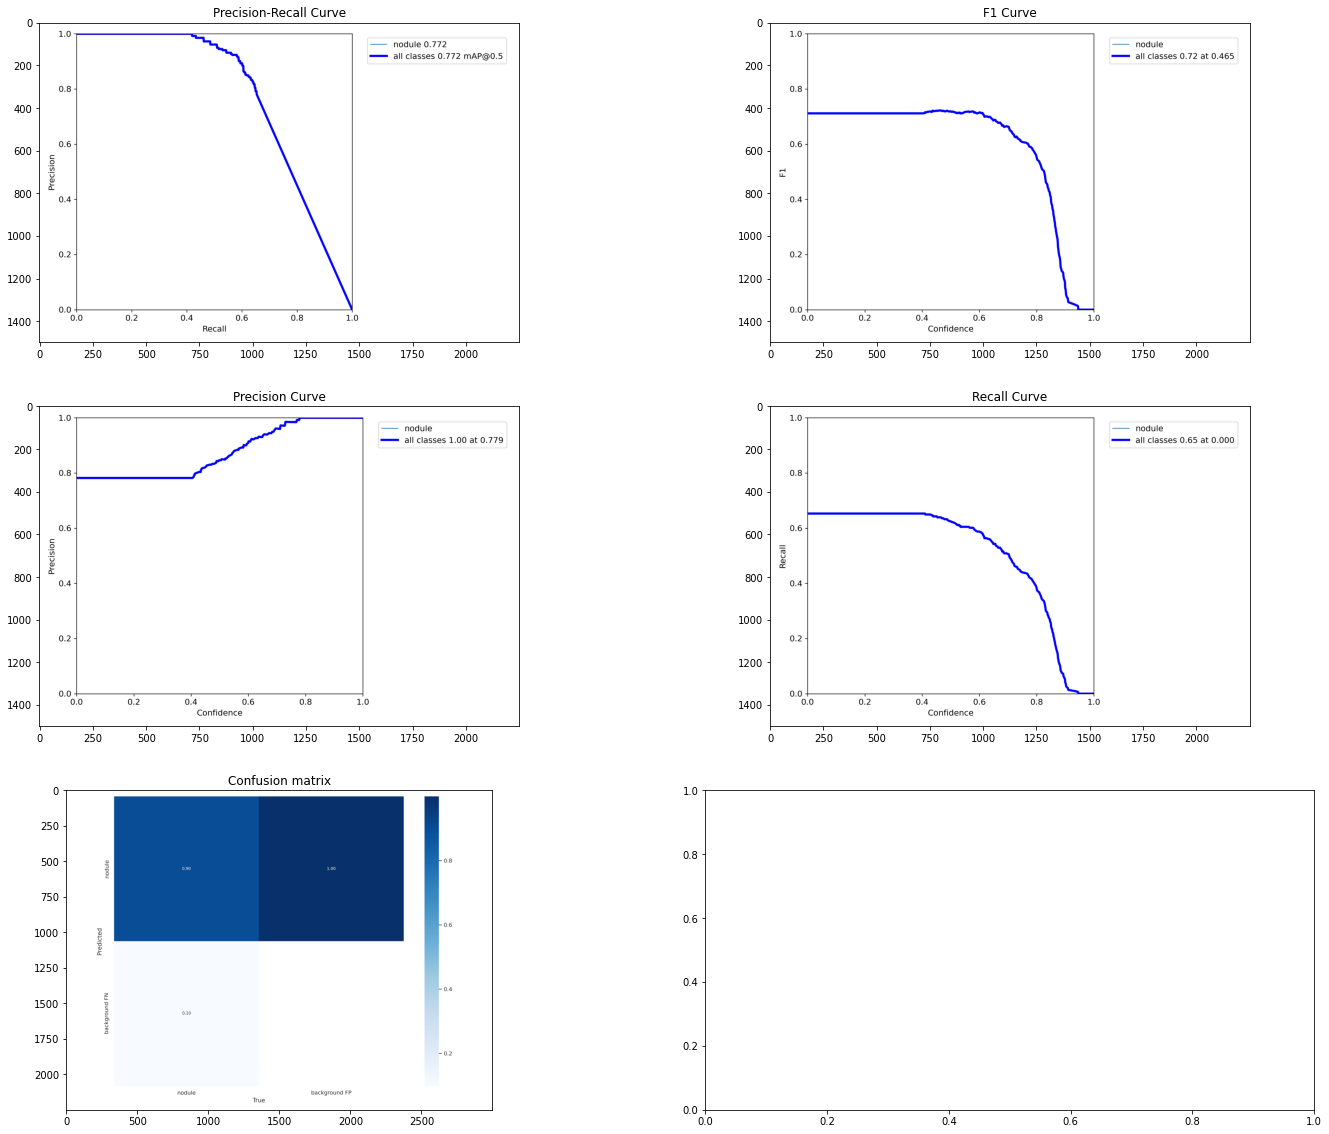

In [29]:
pr = Image.open('runs/val/exp2/PR_curve.png')
f1 = Image.open('runs/val/exp2/F1_curve.png')
cm = Image.open('runs/val/exp2/confusion_matrix.png')
p = Image.open('runs/val/exp2/P_curve.png')
r = Image.open('runs/val/exp2/R_curve.png')

f, a = plt.subplots(3, 2, figsize=(24,20))
a[0][0].imshow(np.array(pr))
a[0][0].set_title('Precision-Recall Curve')
a[0][1].imshow(np.array(f1))
a[0][1].set_title('F1 Curve')
a[1][0].imshow(np.array(p))
a[1][0].set_title('Precision Curve')
a[1][1].imshow(np.array(r))
a[1][1].set_title('Recall Curve')
a[2][0].imshow(np.array(cm))
a[2][0].set_title('Confusion matrix')
plt.show()

In [30]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [40]:
#code ref: https://github.com/JenifferWuUCLA/pulmonary-nodules-segmentation/blob/master/tianchi_segment_lung_ROI.ipynb
def preprocess_image(img):
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    #　to renormalize washed out images
    #middle = img[100:400, 100:400]
    middle = img
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    #　underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    # Using Kmeans to separate foreground (radio-opaque tissue)
    #　and background (radio transparent tissue ie lungs)
    # Doing this only on the center of the image to avoid
    #　the non-tissue parts of the image as much as possible
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
    dilation = morphology.dilation(eroded, np.ones([10, 10]))
    labels = measure.label(dilation)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)

    mask = np.zeros_like(labels)
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)

    mask = morphology.dilation(mask, np.ones([10, 10]))  # one last dilation
    return img * mask

In [125]:
import os, shutil
import glob
from tqdm import tqdm

def removedir(dirname):
    print("Directory {} exists, removing!".format(dirname))
    files = glob.glob(dirname + "/*")
    for i in tqdm(range(len(files))):
        if os.path.isdir(files[i]):
            shutil.rmtree(files[i])
            

"""
    test_dir: where images images for prediction are saved
    temp_dir: where the preprocessed images are saved
"""
def save_patient_image_and_bbox(patient_id, dicom_dir, normalize=False, temp_dir='/app/data/temp/', test_dir='/app/data/yolov5/temp'):
    
    # create the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = test_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
     
    #clean up any previous data for this patient
    if os.path.exists(patientdir):
        print("Removing dir {}".format(patientdir))
        removedir(patientdir)

    print("Creating directory {}".format(imagedirname))
    os.makedirs(imagedirname)

    print("Creating directory {}".format(labeldirname))
    os.makedirs(labeldirname)
    
    # configure the pylidc dirs
    print("Setting DICOM dir = {}".format(dicom_dir))
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()
    
    # query the image data from the CT volume
    print("Reading data for patient {}".format(patient_id))
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    # save the image, even if it does not have any nodules, this will be used for predictions
    if nodule_num <= 0: # no nodules
        num_slices = vol.shape[2]
        im = vol[:,:,int(num_slices/2)]
        
        if normalize:
            im = im - np.mean(im)
            im = im / np.std(im)
        try:
            # in order to preserve the richness of the image, imageio is used to save and then read the image back from the disk
            # TODO: could potentially do it in memory as well
            # TODO: create the temp folder
            imageio.imwrite(temp_dir + '/temp_img.jpg', im)
            disk_img = cv2.imread(temp_dir + '/temp_img.jpg')
        except:
            return
        
        im = cv2.cvtColor(disk_img, cv2.COLOR_BGR2GRAY)
        img_t = preprocess_image(im)
        
        
        image_filename = "{}_{}.jpg".format(patient_id, int(num_slices/2))
        print("Saving image to file {}".format(imagedirname + "/" + image_filename))
        imageio.imwrite(imagedirname + "/" + image_filename, img_t)
    else: # when there are nodules present
        for i in range(nodule_num):
            cmask = cmask_CT[i]
            cbbox = cbbox_CT[i]
            masks = masks_CT[i]
            CT_mask[cbbox] += cmask
            img_count = 0
            for k_slice in np.arange(cbbox[2].start, cbbox[2].stop):
                im = vol[:,:,k_slice]
                
                if normalize:
                    im = im - np.mean(im)
                    im = im / np.std(im)
                try:
                    # in order to preserve the richness of the image, imageio is used to save and then read the image back from the disk
                    # TODO: could potentially do it in memory as well
                    # TODO: create the temp folder
                    imageio.imwrite(temp_dir + '/temp_img.jpg', im)
                    disk_img = cv2.imread(temp_dir + '/temp_img.jpg')
                except:
                    continue

                im = cv2.cvtColor(disk_img, cv2.COLOR_BGR2GRAY)
                img_t = preprocess_image(im)
        
                msk = CT_mask[:,:,k_slice]
                boxes = get_bounding_box(msk)
                if boxes:
                    for box in boxes:
                        x, y, w, h = box
                        if x is not None:
                            image_filename = "{}_{}_{}.jpg".format(patient_id, i, k_slice)
                            
                            noduledir = imagedirname + "/" + str(i)
                            if not os.path.exists(noduledir):
                                os.makedirs(noduledir)
                            print("Saving image {}".format(noduledir + "/" + image_filename))
                            imageio.imwrite(noduledir + "/" + image_filename, img_t)
                            c = 0
                            label = "{} {} {} {} {}".format(c, x, y, w, h)
                            label_filename = "{}_{}_{}.txt".format(patient_id, i, k_slice)
                            labeldir = labeldirname + "/" + str(i)
                            if not os.path.exists(labeldir):
                                os.makedirs(labeldir)
                            print("Saving label {}".format(labeldir + "/" + label_filename))
                            f = open(labeldir + "/" + label_filename, "a")
                            f.write(label)
                            f.close()
                            img_count += 1
                    print("Saved {} images for nodule {} of patient {}".format(img_count, i, patient_id))
    return nodule_num, imagedirname, labeldirname

For a given patient, generate the images for each nodule and the labels

In [165]:
model_weights = '/app/yolov5/runs/train/yolov5s_results28/weights/best.pt'

In [197]:
import math
def plot_detections(result_dir='/app/yolov5/runs/detect/exp14'):
    images = os.listdir(result_dir)
    num_images_row = 3
    print("Number of images {}".format(len(images)))
    if len(images) >= num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, 3, figsize=(14, 15))
    else:
        f, a = plt.subplots(1, len(images), figsize=(14, 15))
    c = 0
    for idx, img in enumerate(images):
        img = Image.open(result_dir + "/" + img)
        if c > num_images_row-1:
            c = 0
        if isinstance(a[0], np.ndarray):
            a[int(idx/num_images_row)][c].imshow(np.array(img))
        else:
            a[c].imshow(np.array(img))
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()

In [184]:
a = np.array([[1,2],[2,3]])
isinstance(a, np.ndarray)

True

#### Routine to predict nodules

Input: 
- patient id -> enter the patient id
- testdir -> the dir where the images for the patient are extracted an placed
- nodule_num -> the number of nodules as per ground truth in the patient

In [108]:
root_dir = '/app/yolov5'

In [168]:
import re
import subprocess
def predict_nodules(patient_id, testdir, nodule_num, root_dir, imagedir, labeldir):
    predicted_paths = []
    for nodule in range(nodule_num):
        source_dir = imagedir + "/" + str(nodule)
        temp_dir = root_dir + '/temp'
        if not os.path.exists(temp_dir):
            os.makedirs(temp_dir)
        temp_file = temp_dir + "/" + 'temp.txt'
        print("Reading data from {}".format(source_dir))
        predict_command = "python detect.py --weights {} --img 512 --conf 0.25 --source {} 2>&1 | tee {}".format(model_weights, source_dir, temp_file)
        print("Running command:\n")
        print(predict_command)
        ret_code = os.system(predict_command)
        print("Command executed with code {}".format(ret_code))
        print("Scanning output file {}".format(temp_file))
        with open(temp_file) as f:
            line = f.read()
            rc = re.compile(r'Results saved to (.*)')
            m = rc.search(line)
            if (m is not None) and (len(m.groups())>=1):
                ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
                result = ansi_escape.sub('', m[1])
                print("Predicted and saved the results to {}/{}".format('/app/yolov5', result))
            else:
                print("Could not save the predictions!")
            predicted_paths.append('/app/yolov5' + "/" + result)
    return predicted_paths

### Test pipeline for a patient

- For a patient id, extract the images and the ground truth bounding box coordinates and save them in one directory, one directory per nodule
- Run the prediction using the bext weights and save the results
- Plot the predictions and compare with the actual images and the ground truth bounding box

In [213]:
testdir = '/app/data/yolov5/temp/'
dicomdir = '/app/data/lidc/dicom/test/sorted_gcsfiles/'
patient_id = 'LIDC-IDRI-0012'
nodule_num, imagedirname, labeldirname = save_patient_image_and_bbox(patient_id, dicomdir, testdir)
print("Found {} nodules in patient {}".format(nodule_num, patient_id))
predicted_paths = predict_nodules(patient_id, testdir, nodule_num, testdir, imagedirname, labeldirname)
print("Found a total of {} nodules".format(len(predicted_paths)))

Creating directory /app/data/yolov5/temp/LIDC-IDRI-0012/images
Creating directory /app/data/yolov5/temp/LIDC-IDRI-0012/labels
Setting DICOM dir = /app/data/lidc/dicom/test/sorted_gcsfiles/
Reading data for patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-1.6013318435678874, 3.113924694216479]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0012 is 12


Lossy conversion from float64 to uint8. Range [-1.5974239737022935, 3.044554686986062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.28828041121418996, 2.6108725410490368]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.5958344410101428, 3.329263891972982]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/0/LIDC-IDRI-0012_0_44.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/0/LIDC-IDRI-0012_0_44.txt
Saved 1 images for nodule 0 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.22624130052781447, 2.792382885273157]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.5954840884765404, 3.256641442644927]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/0/LIDC-IDRI-0012_0_45.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/0/LIDC-IDRI-0012_0_45.txt
Saved 2 images for nodule 0 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.22710973380929458, 2.9181094727166714]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6010906814597374, 2.904565932764935]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/0/LIDC-IDRI-0012_0_46.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/0/LIDC-IDRI-0012_0_46.txt
Saved 3 images for nodule 0 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.2419324467044607, 2.4657339591306453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6017354952974567, 2.75084828850397]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/1/LIDC-IDRI-0012_1_52.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/1/LIDC-IDRI-0012_1_52.txt
Saved 1 images for nodule 1 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.2549657920475455, 2.6002035186402117]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6022287866662828, 2.816764533937731]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/1/LIDC-IDRI-0012_1_53.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/1/LIDC-IDRI-0012_1_53.txt
Saved 2 images for nodule 1 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.30395230016137537, 2.5078548174924986]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6052740002283898, 2.726503555134191]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/1/LIDC-IDRI-0012_1_54.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/1/LIDC-IDRI-0012_1_54.txt
Saved 3 images for nodule 1 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.33275291956758424, 2.491660963403089]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6066595239561348, 2.5762244416426716]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/2/LIDC-IDRI-0012_2_56.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/2/LIDC-IDRI-0012_2_56.txt
Saved 1 images for nodule 2 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.32874367608302646, 2.546145333693319]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6084167677138679, 2.549554290716204]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/2/LIDC-IDRI-0012_2_57.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/2/LIDC-IDRI-0012_2_57.txt
Saved 2 images for nodule 2 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.2728379088953843, 2.5363563497792985]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6189180038628745, 2.7491338619924157]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/2/LIDC-IDRI-0012_2_58.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/2/LIDC-IDRI-0012_2_58.txt
Saved 3 images for nodule 2 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3699969864037131, 2.203618721363078]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6205731173175362, 2.674016375474287]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/3/LIDC-IDRI-0012_3_62.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/3/LIDC-IDRI-0012_3_62.txt
Saved 1 images for nodule 3 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3757922025213667, 2.441095905129092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6210217256306603, 2.775534708218062]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/3/LIDC-IDRI-0012_3_63.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/3/LIDC-IDRI-0012_3_63.txt
Saved 2 images for nodule 3 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3292631970233952, 2.347481281151388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6219695821805953, 2.774277990496564]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/3/LIDC-IDRI-0012_3_64.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/3/LIDC-IDRI-0012_3_64.txt
Saved 3 images for nodule 3 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.34778138905461187, 2.5014628396938123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6210591613829823, 2.6867326735288763]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/3/LIDC-IDRI-0012_3_65.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/3/LIDC-IDRI-0012_3_65.txt
Saved 4 images for nodule 3 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3048146253222152, 2.588507180094076]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6219695821805953, 2.774277990496564]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/3/LIDC-IDRI-0012_3_66.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/3/LIDC-IDRI-0012_3_66.txt
Saved 5 images for nodule 3 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.34778138905461187, 2.5014628396938123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.34778138905461187, 2.5014628396938123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6210591613829823, 2.6867326735288763]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/4/LIDC-IDRI-0012_4_65.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/4/LIDC-IDRI-0012_4_65.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/4/LIDC-IDRI-0012_4_65.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/4/LIDC-IDRI-0012_4_65.txt
Saved 2 images for nodule 4 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3048146253222152, 2.588507180094076]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.3048146253222152, 2.588507180094076]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6186325580298195, 2.6339649202864766]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/4/LIDC-IDRI-0012_4_66.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/4/LIDC-IDRI-0012_4_66.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/4/LIDC-IDRI-0012_4_66.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/4/LIDC-IDRI-0012_4_66.txt
Saved 4 images for nodule 4 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.2858741523846911, 2.603637148964894]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6219695821805953, 2.774277990496564]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/4/LIDC-IDRI-0012_4_67.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/4/LIDC-IDRI-0012_4_67.txt
Saved 5 images for nodule 4 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.34778138905461187, 2.5014628396938123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.34778138905461187, 2.5014628396938123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6210591613829823, 2.6867326735288763]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_65.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_65.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_65.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_65.txt
Saved 2 images for nodule 5 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3048146253222152, 2.588507180094076]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.3048146253222152, 2.588507180094076]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.3048146253222152, 2.588507180094076]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6186325580298195, 2.6339649202864766]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_66.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_66.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_66.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_66.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_66.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_66.txt
Saved 5 images for nodule 5 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.2858741523846911, 2.603637148964894]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2858741523846911, 2.603637148964894]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6183729241487916, 2.6921518331338445]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_67.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_67.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_67.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_67.txt
Saved 7 images for nodule 5 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.35203289537238514, 2.661806702274353]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.619915331288583, 2.6670015070249087]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/5/LIDC-IDRI-0012_5_68.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/5/LIDC-IDRI-0012_5_68.txt
Saved 8 images for nodule 5 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-1.6229071555792074, 2.775746817091408]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.41750003048487727, 2.74434912940275]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6233496047637288, 2.8496945620584553]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/6/LIDC-IDRI-0012_6_70.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/6/LIDC-IDRI-0012_6_70.txt
Saved 1 images for nodule 6 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3266738494948924, 2.800518211933599]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6236358056075744, 2.8701817127515232]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/6/LIDC-IDRI-0012_6_71.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/6/LIDC-IDRI-0012_6_71.txt
Saved 2 images for nodule 6 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3565324385216258, 2.6617788797239466]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6200940252765188, 3.695115813911129]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/6/LIDC-IDRI-0012_6_72.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/6/LIDC-IDRI-0012_6_72.txt
Saved 3 images for nodule 6 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.37080882175645624, 3.555310589653968]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.619148357822233, 3.7027709458175857]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/7/LIDC-IDRI-0012_7_76.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/7/LIDC-IDRI-0012_7_76.txt
Saved 1 images for nodule 7 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3684513420702075, 3.5625803082570786]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6201396947424012, 3.519537262992162]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/7/LIDC-IDRI-0012_7_77.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/7/LIDC-IDRI-0012_7_77.txt
Saved 2 images for nodule 7 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6200940252765188, 3.695115813911129]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/7/LIDC-IDRI-0012_7_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/7/LIDC-IDRI-0012_7_78.txt
Saved 3 images for nodule 7 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.37080882175645624, 3.555310589653968]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.37080882175645624, 3.555310589653968]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.619148357822233, 3.7027709458175857]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_76.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_76.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_76.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_76.txt
Saved 2 images for nodule 8 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3684513420702075, 3.5625803082570786]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.3684513420702075, 3.5625803082570786]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6201396947424012, 3.519537262992162]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_77.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_77.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_77.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_77.txt
Saved 4 images for nodule 8 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6192061063066205, 3.1259313492745306]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_78.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_78.txt
Saved 6 images for nodule 8 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.29977493144434164, 2.5710237664202276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6201396947424012, 3.519537262992162]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/8/LIDC-IDRI-0012_8_79.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/8/LIDC-IDRI-0012_8_79.txt
Saved 7 images for nodule 8 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6192061063066205, 3.1259313492745306]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/9/LIDC-IDRI-0012_9_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/9/LIDC-IDRI-0012_9_78.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/9/LIDC-IDRI-0012_9_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/9/LIDC-IDRI-0012_9_78.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/9/LIDC-IDRI-0012_9_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/9/LIDC-IDRI-0012_9_78.txt
Saved 3 images for nodule 9 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.29977493144434164, 2.5710237664202276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.29977493144434164, 2.5710237664202276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.618902687675992, 3.2806497325364954]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/9/LIDC-IDRI-0012_9_79.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/9/LIDC-IDRI-0012_9_79.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/9/LIDC-IDRI-0012_9_79.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/9/LIDC-IDRI-0012_9_79.txt
Saved 5 images for nodule 9 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3140442231514361, 2.650285571309113]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.619724742122704, 3.3709605972439927]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/9/LIDC-IDRI-0012_9_80.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/9/LIDC-IDRI-0012_9_80.txt
Saved 6 images for nodule 9 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-1.6201396947424012, 3.519537262992162]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.311220009803907, 2.515657708652596]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6192061063066205, 3.1259313492745306]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_78.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_78.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_78.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_78.txt
Saved 3 images for nodule 10 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.29977493144434164, 2.5710237664202276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.29977493144434164, 2.5710237664202276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.29977493144434164, 2.5710237664202276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.618902687675992, 3.2806497325364954]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_79.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_79.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_79.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_79.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_79.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_79.txt
Saved 6 images for nodule 10 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3140442231514361, 2.650285571309113]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.3140442231514361, 2.650285571309113]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.619397758574732, 3.4498086287325798]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_80.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_80.txt
Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/10/LIDC-IDRI-0012_10_80.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/10/LIDC-IDRI-0012_10_80.txt
Saved 8 images for nodule 10 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.4287952439327427, 2.618447165723502]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6185113936652147, 3.4665915724907337]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/11/LIDC-IDRI-0012_11_82.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/11/LIDC-IDRI-0012_11_82.txt
Saved 1 images for nodule 11 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.363457578312365, 2.9126927841453063]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6167531399528008, 3.2669282448869876]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/11/LIDC-IDRI-0012_11_83.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/11/LIDC-IDRI-0012_11_83.txt
Saved 2 images for nodule 11 of patient LIDC-IDRI-0012


Lossy conversion from float64 to uint8. Range [-0.3926886394764619, 3.0610026063687026]. Convert image to uint8 prior to saving to suppress this warning.


Saving image /app/data/yolov5/temp/LIDC-IDRI-0012/images/11/LIDC-IDRI-0012_11_84.jpg
Saving label /app/data/yolov5/temp/LIDC-IDRI-0012/labels/11/LIDC-IDRI-0012_11_84.txt
Saved 3 images for nodule 11 of patient LIDC-IDRI-0012
Found 12 nodules in patient LIDC-IDRI-0012
Reading data from /app/data/yolov5/temp/LIDC-IDRI-0012/images/0
Running command:

python detect.py --weights /app/yolov5/runs/train/yolov5s_results28/weights/best.pt --img 512 --conf 0.25 --source /app/data/yolov5/temp/LIDC-IDRI-0012/images/0 2>&1 | tee /app/data/yolov5/temp//temp/temp.txt
Command executed with code 0
Scanning output file /app/data/yolov5/temp//temp/temp.txt
Predicted and saved the results to /app/yolov5/runs/detect/exp137
Reading data from /app/data/yolov5/temp/LIDC-IDRI-0012/images/1
Running command:

python detect.py --weights /app/yolov5/runs/train/yolov5s_results28/weights/best.pt --img 512 --conf 0.25 --source /app/data/yolov5/temp/LIDC-IDRI-0012/images/1 2>&1 | tee /app/data/yolov5/temp//temp/temp.t

Number of images 5


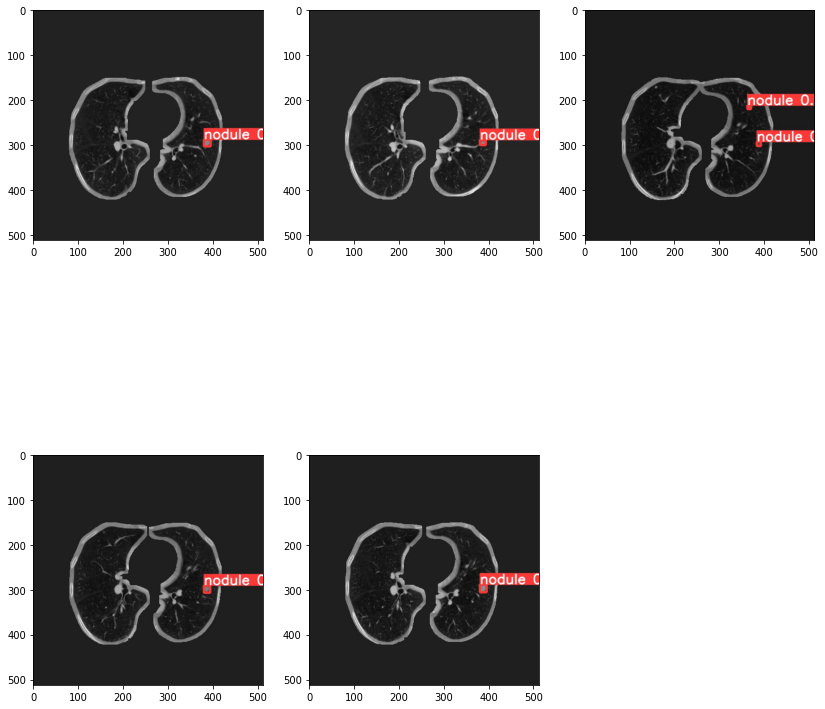

In [217]:
plot_detections(predicted_paths[3])

#### Plot and compare the predicted bounding box vs the actual bounding box

In [172]:
import matplotlib.patches as patches
def plot_and_compare(predicted_paths, patient_id, nodule_num, test_root_dir=testdir):
    
    #get the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = test_root_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
    
    
    images = os.listdir(predicted_paths[nodule_num])
    labeldir = labeldirname + "/" + str(nodule_num)
    print("Loading labels from {}".format(labeldir))
    labels = os.listdir(labeldir)
    
    imagedir = imagedirname + "/" + str(nodule_num)
    source_images = os.listdir(imagedir)
    
    num_images_row = 1
    print("Number of images {}".format(len(images)))
    if len(images) > num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, num_images_row*2, figsize=(14, 35))
    c = 0
    for idx, (imgstr, src_imgstr) in enumerate(zip(images, source_images)):
        img = Image.open(predicted_paths[nodule_num] + "/" + imgstr)
        src_img = Image.open(imagedir + "/" + src_imgstr)
        if c > num_images_row-1:
            c = 0
        a[int(idx/num_images_row)][c].imshow(np.array(img))
        a[int(idx/num_images_row)][c+1].imshow(np.array(src_img))
        src_labelstr = src_imgstr.replace('.jpg','.txt')
        
        with open(labeldir + "/" + src_labelstr) as f:
            line = f.read()
            cls, x, y, w, h = line.split(' ')
            x, y, w, h = float(x), float(y), float(w), float(h)
            rect = patches.Rectangle((x, y), (w), (h), linewidth=1, edgecolor='r', facecolor='none')
            a[int(idx/num_images_row)][c+1].add_patch(rect)
            
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()

Loading labels from /app/data/yolov5/temp/LIDC-IDRI-0012/labels/3
Number of images 5


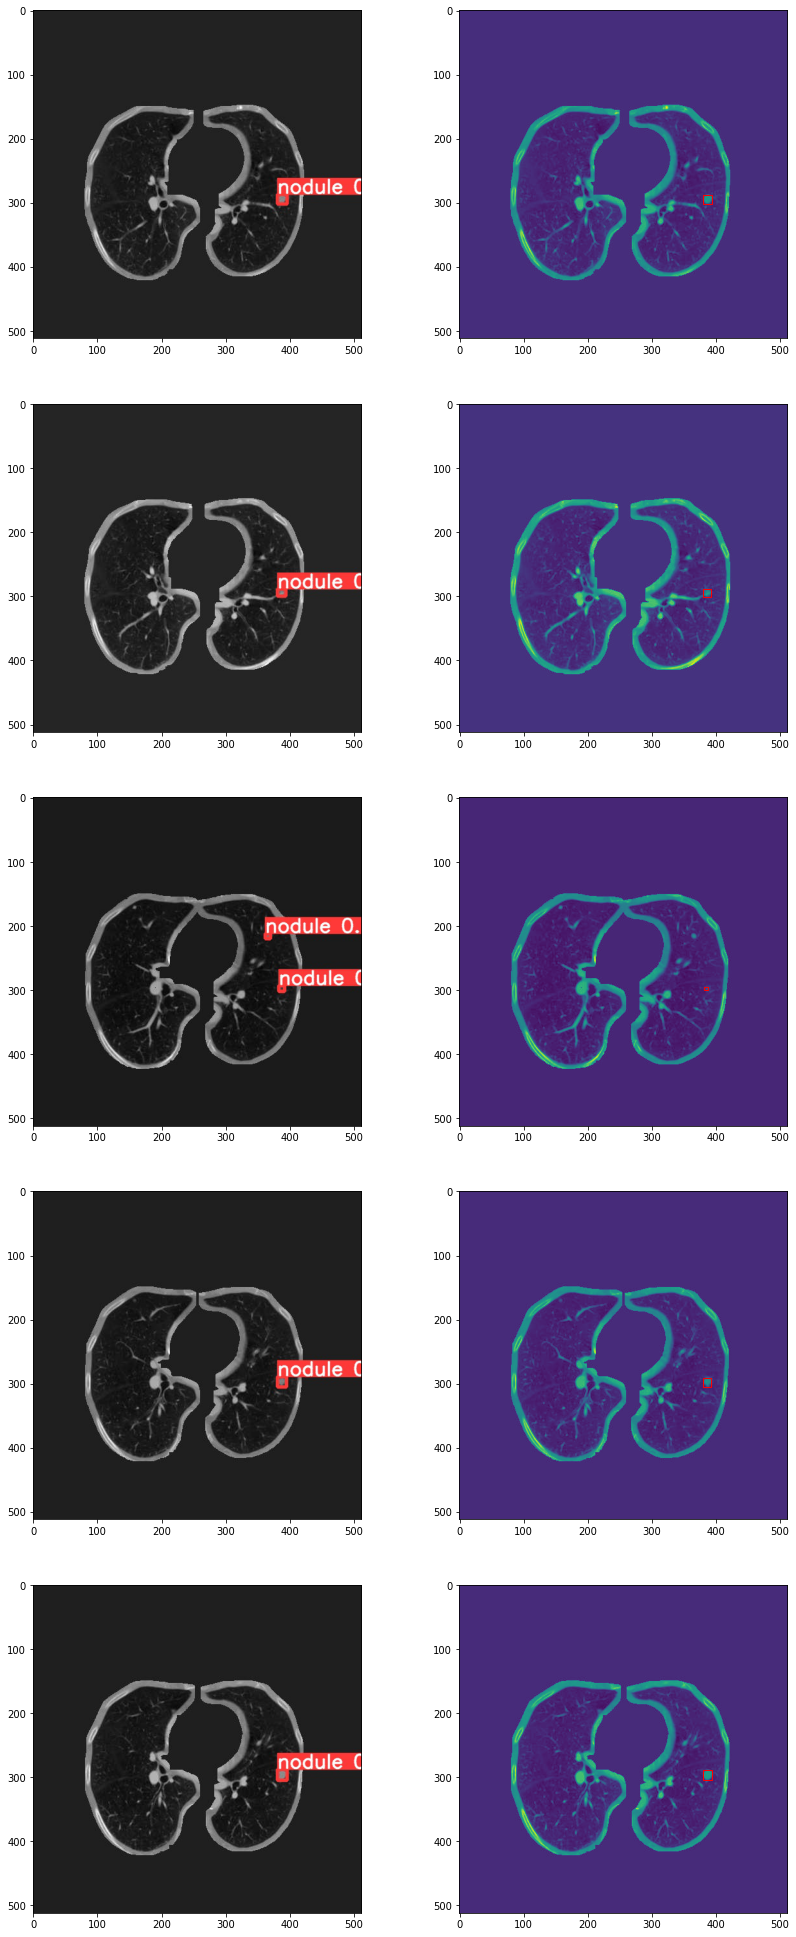

In [218]:
plot_and_compare(predicted_paths, 'LIDC-IDRI-0012', 3, '/app/data/yolov5/temp')